# Introduction

In this notebook, we are putting Deep Learning models in to practices.

With the dataset of ***360 Fruit***, which includes around a hundred of fruit families with hundreds images for each, we are using:
* A ***handmade-by-me CNN***.
* A state-of-the-OLD-art: ***LeNet5***
* Transform learning with the giant ***ResNet-152***
* Transform learning with the tiny ***SqueezeNet***

Then, each model practicing following by a classification report and a tunning.

At last, we will discuss which one is the best, why, how, and other questions.


***Dataset properties***

* Total number of images: 90483.
* Training set size: 67692 images (one fruit or vegetable per image).
* Test set size: 22688 images (one fruit or vegetable per image).
* Multi-fruits set size: 103 images (more than one fruit (or fruit class) per image)
* Number of classes: ***131*** (fruits and vegetables).
* Image size: ***100x100*** pixels.

# Import Packages

In [1]:
# Bases
import keras as k
import tensorflow as tf

## data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, LayerNormalization, GlobalAveragePooling2D

## plotting
import os
import numpy as np
import matplotlib.pyplot as plt

## callbacks
from keras.callbacks import TensorBoard
import time

from keras.applications import ResNet152
from keras import Input, Model

Using TensorFlow backend.


## Environment Config for GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

memory_limit=1024
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit),
         #tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit),
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16848646179467071471
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4773542265022904184
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1073741824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15049207276619755419
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6494146148485401514
physical_device_desc: "device: XLA_GPU device"
]


# Prepare Data

The dataset has the following directory ***structure***:

<pre>
<b>Fruit Images Dataset</b>
|__ <b>train</b>
    |______ <b>Apple Braeburn</b>: [0_100.jpg, ..]
    |______ <b>Apple Crimson Snow</b>: [0_100.jpg, ..] 
    ..
    |______ <b>Apple Watermelon</b>: [0_100.jpg, ..]
|__ <b>test</b>
    |______ <b>Apple Braeburn</b>: [0_100.jpg, ..]
    |______ <b>Apple Crimson Snow</b>: [0_100.jpg, ..] 
    ..
    |______ <b>Apple Watermelon</b>: [0_100.jpg, ..]
</pre>

***How to prepare data***

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`, which can:
* Read images and preprocess them into proper tensors. 
* Set up generators that convert these images into batches of tensors — helpful when training the network.

In [6]:
# Generator
train_generator = ImageDataGenerator(rescale=1/255)
val_generator = ImageDataGenerator(rescale=1/255)

## Variable for pre-processing and training

In [7]:
batch_size = 64
epochs = 15

IMG_HEIGHT = 100
IMG_WIDTH = 100

num_classes = 131

where_train = '/home/maihai/GitHub/Fruit-Images-Dataset/train'
where_test  = '/home/maihai/GitHub/Fruit-Images-Dataset/test'

After defining the generators, the `flow_from_directory` method will:
* Load images from the disk,
* Applies rescaling,
* Applies resizes images into the required dimensions.

In [8]:
train_data_gen = train_generator.flow_from_directory(directory=where_train, 
                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                         class_mode='categorical',
                                         shuffle=True,
                                         batch_size=batch_size)

Found 67692 images belonging to 131 classes.


In [9]:
val_data_gen = val_generator.flow_from_directory(directory=where_test,
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        class_mode='categorical',
                                        shuffle=True,
                                        batch_size=batch_size)

Found 22688 images belonging to 131 classes.


## Visualize Training Images

To visualize the training images, we will:
* Extracting a batch from the training generator — which is 32 images
* Then plot five of them with `matplotlib`.

In [10]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset, which is in form of `(x_train, y_train)`. We discard the labels to only visualize the training images.

In [11]:
# This function: plots images in the form of a 1 row x 5 cols grid.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

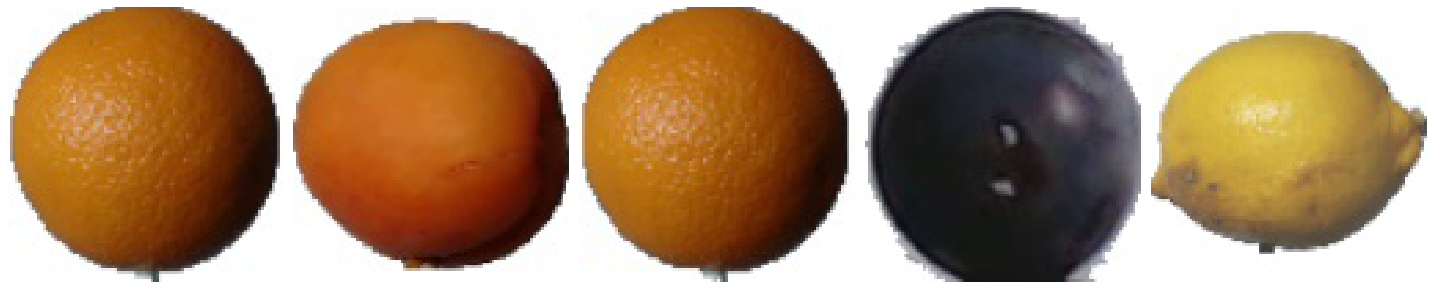

In [12]:
plotImages(sample_training_images[:5])

# The Handmade Model

## Create and train the model

In [13]:
model_baseline = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(131, activation = 'softmax')
])

In [14]:
model_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

In [15]:
model_baseline.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy', 'AUC'])

In [17]:
# Set up TensorBoard
NAME = 'Handmade_model_baseline_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [19]:
%%time
# Train model_baseline
history = model_baseline.fit(train_data_gen,
                             steps_per_epoch=67692 // batch_size,
                             epochs=epochs,
                             validation_data=val_data_gen,
                             validation_steps=22688 // batch_size,
                             callbacks=[tensorboard])

Epoch 1/15
1057/1057 [==============================] - 35s 33ms/step - loss: 0.0221 - categorical_accuracy: 0.9942 - auc: 0.9997 - val_loss: 0.2723 - val_categorical_accuracy: 0.9462 - val_auc: 0.9925
Epoch 2/15
1057/1057 [==============================] - 34s 33ms/step - loss: 0.0118 - categorical_accuracy: 0.9968 - auc: 0.9998 - val_loss: 0.1461 - val_categorical_accuracy: 0.9722 - val_auc: 0.9948
Epoch 3/15
1057/1057 [==============================] - 34s 32ms/step - loss: 3.0561e-04 - categorical_accuracy: 0.9999 - auc: 1.0000 - val_loss: 0.1489 - val_categorical_accuracy: 0.9746 - val_auc: 0.9948
Epoch 4/15
1057/1057 [==============================] - 34s 32ms/step - loss: 1.6346e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2615 - val_categorical_accuracy: 0.9441 - val_auc: 0.9917
Epoch 5/15
1057/1057 [==============================] - 34s 32ms/step - loss: 0.0383 - categorical_accuracy: 0.9901 - auc: 0.9993 - val_loss: 0.1457 - val_categorical_accuracy: 0.9745 

In [20]:
where_to_save = '/home/maihai/GitHub/Portfolio/4_Fruit_classification/Handmade_model_baseline'

model_baseline.save(filepath=where_to_save,
                    overwrite=False,
                    include_optimizer=True)

INFO:tensorflow:Assets written to: /home/maihai/GitHub/Portfolio/4_Fruit_classification/Handmade_model_baseline/assets


## The results

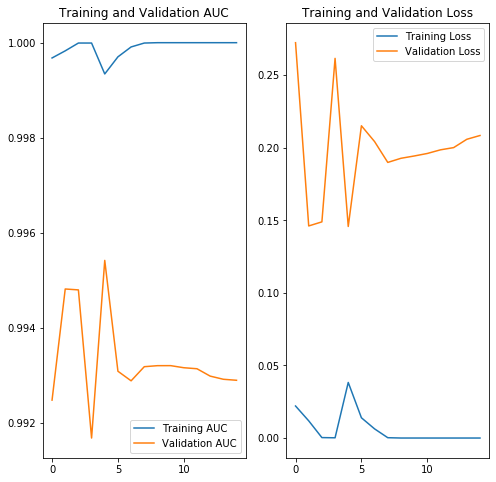

In [27]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Fighting for Better Predictions

Trinh bay ly do: Data aug, Dropout

Even out simplest model gets a quiet good result, but I want to test if is improved by several common techniques, which are:
* Data augmentation
* Dropout.

## Data Augmentation

In [28]:
image_gen = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               rotation_range=45
                               )

In [29]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=where_train,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 67692 images belonging to 131 classes.


In [30]:
sample_training_images, _ = next(train_data_gen)

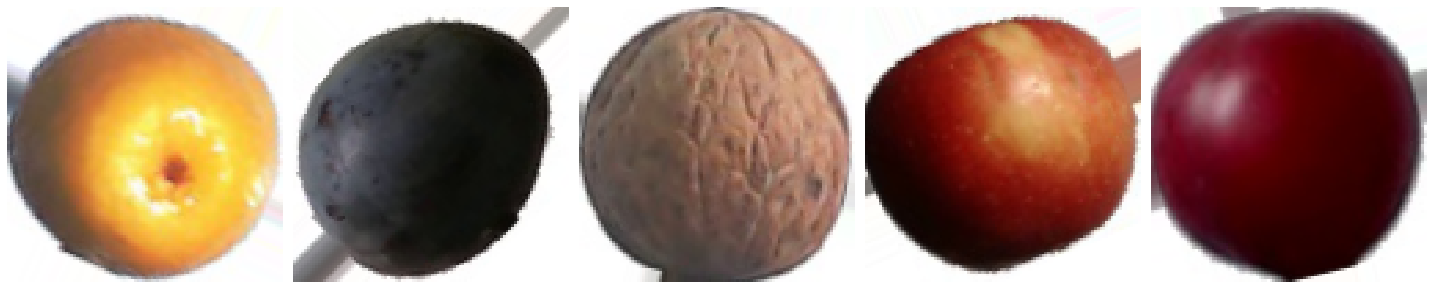

In [31]:
plotImages(sample_training_images[:5])

We only apply image augmentation on the training data, not on the test dataset.  
Because the test set should be remained as its origin.

## Dropout

***What is Dropout***

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in this tutorial

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.

### The new handmade model with Dropout

In [34]:
model_with_dropout = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(131, activation = 'softmax')
])

model_with_dropout.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 64)       

In [35]:
model_with_dropout.compile(optimizer='adam',
                           loss=tf.keras.losses.CategoricalCrossentropy(),
                           metrics=['categorical_accuracy', 'AUC'])

### Train the new handmade modelclassification_report

In [18]:
NAME = 'Handmade_model_Augmentation_Dropout_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [36]:
%%time
history = model_with_dropout.fit(train_data_gen,
                                 steps_per_epoch=67692 // batch_size,
                                 epochs=epochs,
                                 validation_data=val_data_gen,
                                 validation_steps=22688 // batch_size,
                                 callbacks=[tensorboard])

Epoch 1/15
1057/1057 [==============================] - 136s 129ms/step - loss: 0.8071 - categorical_accuracy: 0.7821 - auc: 0.9902 - val_loss: 0.4124 - val_categorical_accuracy: 0.8848 - val_auc: 0.9930
Epoch 2/15
1057/1057 [==============================] - 136s 129ms/step - loss: 0.1049 - categorical_accuracy: 0.9653 - auc: 0.9991 - val_loss: 0.2769 - val_categorical_accuracy: 0.9401 - val_auc: 0.9933
Epoch 3/15
1057/1057 [==============================] - 136s 128ms/step - loss: 0.0683 - categorical_accuracy: 0.9781 - auc: 0.9992 - val_loss: 0.2231 - val_categorical_accuracy: 0.9506 - val_auc: 0.9943
Epoch 4/15
1057/1057 [==============================] - 136s 129ms/step - loss: 0.0556 - categorical_accuracy: 0.9826 - auc: 0.9994 - val_loss: 0.3355 - val_categorical_accuracy: 0.9214 - val_auc: 0.9919
Epoch 5/15
1057/1057 [==============================] - 135s 128ms/step - loss: 0.0466 - categorical_accuracy: 0.9852 - auc: 0.9994 - val_loss: 0.2323 - val_categorical_accuracy: 0.947

In [37]:
where_to_save = '/home/maihai/GitHub/Portfolio/4_Fruit_classification/Handmade_model_Augmentation_Dropout'

model_with_dropout.save(filepath=where_to_save, overwrite=False, include_optimizer=True)

INFO:tensorflow:Assets written to: /home/maihai/GitHub/Portfolio/4_Fruit_classification/Handmade_model_Augmentation_Dropout/assets


### Results

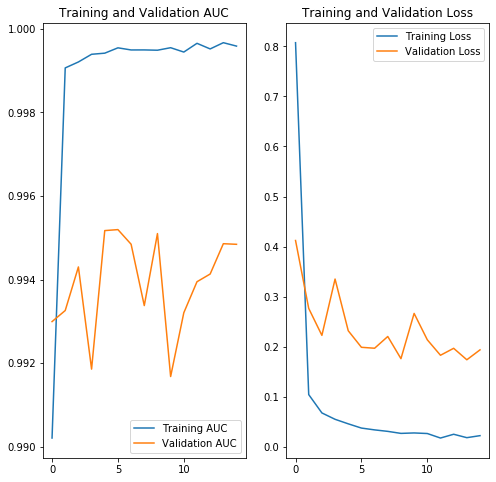

In [39]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Clasification report

In [40]:
import sklearn
from sklearn.metrics import  classification_report

In [41]:
y_pred = model_with_dropout.predict(val_data_gen)
y_pred = np.argmax(Y_pred, axis=1)

ResourceExhaustedError:  OOM when allocating tensor with shape[64,16,100,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_2/conv2d_6/Conv2D (defined at <ipython-input-41-a902e3c6476c>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_279838]

Function call stack:
predict_function


In [ ]:
classification_report(val_data_gen.classes, y_pred)

# The State-of-the-OLD-art: CaffeNet or AlexNet on 1 GPU

![](caffenet.png)

## Data preprocess

In [17]:
batch_size = 64
epochs = 15

IMG_HEIGHT = 224
IMG_WIDTH = 224

where_train = '/home/maihai/GitHub/Fruit-Images-Dataset/train'
where_test  = '/home/maihai/GitHub/Fruit-Images-Dataset/test'

In [18]:
# Generator

## Augmentation for training set only
train_generator = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               rotation_range=45)

val_generator = ImageDataGenerator(rescale=1/255)

In [19]:
train_data_gen = train_generator.flow_from_directory(directory=where_train, 
                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                         class_mode='categorical',
                                         shuffle=True,
                                         batch_size=batch_size)

Found 67692 images belonging to 131 classes.


In [20]:
val_data_gen = val_generator.flow_from_directory(directory=where_test,
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        class_mode='categorical',
                                        shuffle=True,
                                        batch_size=batch_size)

Found 22688 images belonging to 131 classes.


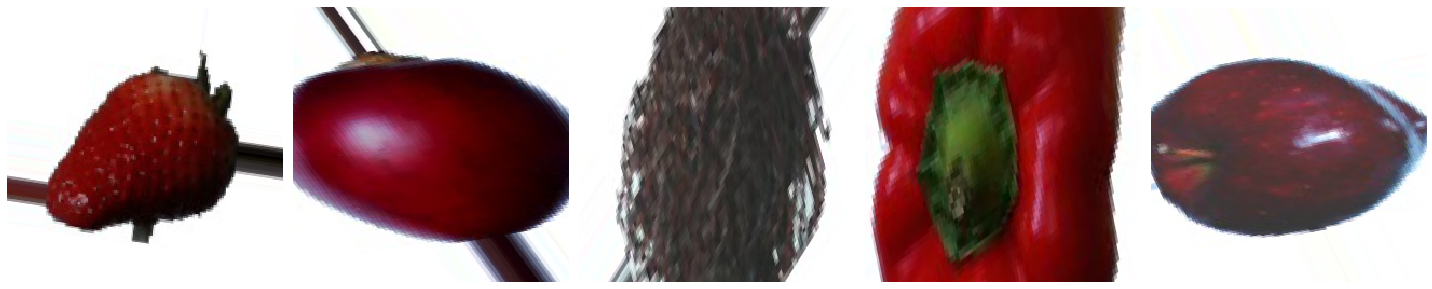

In [21]:
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

## Create the model

![](caffenet.png)

In [30]:
caffe = Sequential([
    # Layer 1
    Conv2D(96, kernel_size=(11, 11), strides=4, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Layer 2
    Conv2D(256, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(),
    LayerNormalization(),
    
    # Layer 3
    Conv2D(384, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(),
    LayerNormalization(),
    
    # Layer 4
    Conv2D(384, kernel_size=(3, 3), activation='relu'),
    
    # Layer 5
    Conv2D(256, kernel_size=(3, 3), activation='relu'), 
    
    # Layer 6
    Dense(4096),
    MaxPooling2D(),
    
    # Layer 7
    Dense(4096),
    
    # Output layeres
    Dense(1000, activation='softmax') # We have 131 classess of fruits
])

In [31]:
caffe.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 62, 62, 96)        34944     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 58, 58, 256)       614656    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 29, 29, 256)       0         
_________________________________________________________________
layer_normalization_18 (Laye (None, 29, 29, 256)       512       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 27, 27, 384)       885120    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 13, 13, 384)       0         
_________________________________________________________________
layer_normalization_19 (Laye (None, 13, 13, 384)      

# The State-of-the-NEW-art: ResNet 152

***ResNet 152***, published by Google in 2015. ResNet 152 as its name includes a very deep networks of 152 layers, addressing the problem of information vanishing by Resudual architecture, which skip connection while computing.

ResNet was the winner of all stars in 2015, then embeded in Keras with pre-trained weighted of ***'imagenet'***.

## The typical transfer learning workflow

***Workflow 1***

In this project, we will use transfer learning technique to apply ResNet 152 architecture on our Fruit dataset.

1. ***Instantiate*** the ResNet then load pre-trained weights.
2. ***Freeze*** all layers by setting ResNet152.trainable = False.
3. ***Create*** our custom layers on top of the Resnet's output.
4. ***Train*** only our custom layers.




***Workflow 2***  

Workflow 1 has a backdraw in my computer: out of memory. Though we marked ResNet's core layers to be skiped while training, but all of them still be loaded to memory, the number is around 60 millions. The number that big is unable for my computer to work with. So, let's try an alternative approach, much cheaper and more lightweight.  
1. ***Instantiate*** the ResNet and load pre=trained weights.
2. ***Run*** our Fruit dataset through it, then receive the output. This is called ***feature extraction***.
3. ***Use*** that output as input for a new, smaller model.  

By this workflow, the need for memory would highly decrease.

***Fine tuning***  

Either your choice is Workflow 1 or 2, afterall, we have a basical transfer-learning models, with most of weights belong to the core ResNet and a minority of our custom layers. Then, we need to adjust those ResNet weights to the Fruit dataset. The steps are follow:

1. ***Unfreeze*** ResNet's core layers by setting ResNet152.trainable = True.
2. ***Train*** the entire model, both top layers and the core.  

### The workflow 1

In [16]:
# 1 Instantiate
resnet = ResNet152(weights='imagenet',
                   input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                   include_top=False) # to adopt our fruit classifier
# 2 Freeze
resnet.trainable = False

# 3 Create new model on top
inputs  = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x       = resnet(inputs)
x = k.layers.GlobalAveragePooling2D()(x) # Convert features of shape `resnet.output_shape[1:]` to vectors
outputs = k.layers.Dense(num_classes)(x)

resnet_copycat = Model(inputs, outputs)
resnet_copycat.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
resnet152 (Model)            (None, 4, 4, 2048)        58370944  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 131)               268419    
Total params: 58,639,363
Trainable params: 268,419
Non-trainable params: 58,370,944
_________________________________________________________________


In [17]:
resnet_copycat.compile(optimizer='adam',
                       loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                       metrics=['accuracy'])

In [19]:
NAME = 'Resnet_copycat_flow_1_{}'.format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [20]:
%%time
# 4 Training our top layers
history = resnet_copycat.fit(train_data_gen,
                             steps_per_epoch=67692 // batch_size,
                             epochs=epochs,
                             validation_data=val_data_gen,
                             validation_steps=22688 // batch_size,
                             callbacks=[tensorboard])

Epoch 1/15
 135/1057 [==>...........................] - ETA: 5:37 - loss: 0.0497 - accuracy: 0.3697

KeyboardInterrupt: 

In [18]:
where_to_save = '/home/maihai/GitHub/Portfolio/4_Fruit_classification/resnet_copycat_flow_2'

model_baseline.save(filepath=where_to_save, overwrite=False, include_optimizer=True)

[WARNING] /home/maihai/GitHub/Portfolio/4_Fruit_classification/model_baseline already exists - overwrite? [y/n] y


[TIP] Next time specify overwrite=True!
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/maihai/GitHub/Portfolio/4_Fruit_classification/model_baseline/assets


### Fine-tuning of the entire model

Finally, let's unfreeze the base model and train the entire model end-to-end with a low learning rate.

In [ ]:
resnet.trainable = True

resnet_copycat.compile(optimizer='adam',
                       loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                       metrics=['accuracy'])

In [37]:
%%time
#### Please, don't run this block. 
## GPU has not enough VRAM to train it.
## CPU got 38 mins for each epoch.
## This block is so expensive, don't run it.

# Setting up TensorBoard
NAME = 'Handmade_model_resnet_copycat_fineTune{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

# Training
with tf.device('/cpu:0'):
    history = resnet_copycat.fit(train_data_gen,
                             steps_per_epoch=67692 // batch_size,
                             epochs=epochs,
                             validation_data=val_data_gen,
                             validation_steps=22688 // batch_size,
                             callbacks=[tensorboard]
)

Epoch 1/15
  49/1057 [>.............................] - ETA: 36:45 - loss: 0.0989 - accuracy: 0.0536

KeyboardInterrupt: 

# Evaluate

# Analysis and Compare Models